<a href="https://colab.research.google.com/github/Topofajar/Travt_Recommendation-System/blob/main/model/ML_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System using Collaborative Filtering

In developing a recommendation system, we use collaborative filtering with a neural network in Tensorflow. The attributes utilized include user rating history and data about tourist attractions and restaurants  involve categories, city of origin, overall place rating, and verification status.

## Library

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

## Data Pre-processing

Combining multiple cleaned datasets, we perform feature engineering, encode categorical data, adjust data according to model requirements, and finally, split the data into training and testing sets.

In [ ]:
# Load datasets
tourist_resto_data = pd.read_csv("https://raw.githubusercontent.com/Topofajar/Travt_Recommendation-System/main/Dataset/Tourist%20and%20Resto%20Data.csv")
rating_data = pd.read_csv("https://raw.githubusercontent.com/Topofajar/Travt_Recommendation-System/main/Dataset/Rating%20Data.csv")

tourist_resto_data.head(5)

,place_id,place_maps_id,name,site,subtypes,category,phone,full_address,city,latitude,...,photo 1,photo 2,photo 3,photo 4,working_hours,about,description,verified,location_link,reviews_id
0,1,ChIJiV-3wTiPei4Rgk7HniCGdS0,Tidar Hill,-,"Tourist attraction, National forest, Nature pr...",attractions,+62 293 3193978,"Magersari, South Magelang, Magelang City, Cent...",Magelang City,-7.496565,...,https://lh5.googleusercontent.com/p/AF1QipMG5c...,https://lh5.googleusercontent.com/p/AF1QipOWBM...,https://lh5.googleusercontent.com/p/AF1QipPDos...,https://lh5.googleusercontent.com/p/AF1QipMwCn...,"{""Monday"": ""Open 24 hours"", ""Tuesday"": ""Open 2...","{""Accessibility"": {""Assistive hearing loop"": t...",Tidar Hill adalah destinasi wisata alam yang t...,True,https://www.google.com/maps/place/Tidar+Hill/@...,3275671778642841218
1,2,ChIJ3fo2v2KPei4RvQVDGKOV944,Jembatan Kaca - Jurang Koco Gunung Mujil,http://www.kyailanggeng.com/,Tourist attraction,attractions,-,"G695+84G, Kemirirejo, Magelang Tengah, Magelan...",Magelang City,-7.481695,...,https://lh5.googleusercontent.com/p/AF1QipOyUu...,https://lh5.googleusercontent.com/p/AF1QipMwr8...,https://lh5.googleusercontent.com/p/AF1QipMLBY...,https://lh5.googleusercontent.com/p/AF1QipOc7O...,"{""Monday"": ""8.00am-4.00pm"", ""Tuesday"": ""8.00am...","{""Children"": {""Good for kids"": true}}",Jembatan Kaca - Jurang Koco Gunung Mujil adala...,False,https://www.google.com/maps/place/Jembatan+Kac...,-8144876873356999235
2,3,ChIJ0UZPZl2Pei4Rg_Fgft8rRsM,TKL Ecopark - Taman Kyai Langgeng - Tempat Wis...,https://www.tklecopark.com/,"Tourist attraction, Children's amusement cente...",attractions,+62 293 3192642,"Jl. Cemp. No.6, Kemirirejo, Kec. Magelang Teng...",Magelang City,-7.486083,...,https://lh5.googleusercontent.com/p/AF1QipPya_...,https://lh5.googleusercontent.com/p/AF1QipPPZ1...,https://lh5.googleusercontent.com/p/AF1QipNCmj...,https://lh5.googleusercontent.com/p/AF1QipOZ4N...,"{""Monday"": ""8.00am-5.00pm"", ""Tuesday"": ""8.00am...","{""Accessibility"": {""Wheelchair-accessible car ...","TKL Ecopark, atau dikenal juga sebagai Taman K...",True,https://www.google.com/maps/place/TKL+Ecopark+...,-4375761749045874301
3,4,ChIJ4-bWLF-Pei4RwVtR3bkBYGQ,Indië Water Toren - Waterleidingsysteem voor M...,-,"Tourist attraction, Historical landmark",attractions,-,"G6F9+73P, Jl. Alun-Alun Utara, Kemirirejo, Kec...",Magelang City,-7.476784,...,https://lh5.googleusercontent.com/p/AF1QipN5x6...,https://lh5.googleusercontent.com/p/AF1QipMsRh...,https://lh5.googleusercontent.com/p/AF1QipOSjM...,https://lh5.googleusercontent.com/p/AF1QipNiQb...,"{""Monday"": ""Open 24 hours"", ""Tuesday"": ""Open 2...","{""Accessibility"": {""Wheelchair-accessible entr...",Indië Water Toren adalah landmark sejarah yang...,False,https://www.google.com/maps/place/Indi%C3%AB+W...,7232782899350690753
4,5,ChIJ89E5PVmPei4RY_AbVdJBw7I,"Aniem's ​​Lantaarnpaal - Tugu Aniem "" in de St...",-,"Tourist attraction, Historical landmark",attractions,-,"G6C9+VM2, Jl. Brigjen Katamso, Kemirirejo, Kec...",Magelang City,-7.477853,...,https://lh5.googleusercontent.com/p/AF1QipPMTy...,https://lh5.googleusercontent.com/p/AF1QipPO9t...,https://lh5.googleusercontent.com/p/AF1QipP0co...,https://lh5.googleusercontent.com/p/AF1QipNIUr...,"{""Monday"": ""Open 24 hours"", ""Tuesday"": ""Open 2...","{""Accessibility"": {""Wheelchair-accessible entr...","Aniem's ​​Lantaarnpaal, juga dikenal sebagai T...",False,https://www.google.com/maps/place/Aniem%27s+%E...,-5565532342872969117


In [ ]:
rating_data.head(5)

,user_id,place_id,rating,review
0,21210,1,1,NaN
1,16382,1,1,NaN
2,12739,1,1,NaN
3,23297,1,1,NaN
4,10654,1,1,NaN


In [ ]:
# Check columns
print("Tourist and Resto Data columns:", tourist_resto_data.columns)
print("Rating Data columns:", rating_data.columns)

Tourist and Resto Data columns: Index(['place_id', 'place_maps_id', 'name', 'site', 'subtypes', 'category',
       'phone', 'full_address', 'city', 'latitude', 'longitude', 'location',
       'rating', 'total rating', 'reviews_link', 'rating_per_score_1',
       'rating_per_score_2', 'rating_per_score_3', 'rating_per_score_4',
       'rating_per_score_5', 'photos_count', 'photo 1', 'photo 2', 'photo 3',
       'photo 4', 'working_hours', 'about', 'description', 'verified',
       'location_link', 'reviews_id'],
      dtype='object')
Rating Data columns: Index(['user_id', 'place_id', 'rating', 'review'], dtype='object')


In [ ]:
# Merge datasets
merged_data = pd.merge(rating_data, tourist_resto_data, on='place_id')

# Select relevant columns
merged_data = merged_data[['user_id', 'place_id', 'rating_x', 'category', 'city', 'rating_y', 'verified']]

# Rename columns for clarity
merged_data.columns = ['user_id', 'place_id', 'rating_user', 'category', 'city', 'rating_place', 'verified']
merged_data.head(5)

,user_id,place_id,rating_user,category,city,rating_place,verified
0,21210,1,1,attractions,Magelang City,4.5,True
1,16382,1,1,attractions,Magelang City,4.5,True
2,12739,1,1,attractions,Magelang City,4.5,True
3,23297,1,1,attractions,Magelang City,4.5,True
4,10654,1,1,attractions,Magelang City,4.5,True


In [ ]:
# Create mappings for user, place IDs, category, city, rating_place, verified
user_id_map = {id_: i for i, id_ in enumerate(merged_data['user_id'].unique())}
place_id_map = {id_: i for i, id_ in enumerate(merged_data['place_id'].unique())}
category_map = {id_: i for i, id_ in enumerate(merged_data['category'].unique())}
city_map = {id_: i for i, id_ in enumerate(merged_data['city'].unique())}
rating_place_map = {id_: i for i, id_ in enumerate(merged_data['rating_place'].unique())}
verified_map = {id_: i for i, id_ in enumerate(merged_data['verified'].unique())}

# Map user and place IDs to integers
merged_data['user_id'] = merged_data['user_id'].map(user_id_map)+1
merged_data['place_id'] = merged_data['place_id'].map(place_id_map)+1
merged_data['category'] = merged_data['category'].map(category_map)
merged_data['city'] = merged_data['city'].map(city_map)
merged_data['rating_place'] = merged_data['rating_place'].map(rating_place_map)
merged_data['verified'] = merged_data['verified'].map(verified_map)

merged_data

,user_id,place_id,rating_user,category,city,rating_place,verified
0,1,1,1,0,0,0,0
1,2,1,1,0,0,0,0
2,3,1,1,0,0,0,0
3,4,1,1,0,0,0,0
4,5,1,1,0,0,0,0
...,...,...,...,...,...,...,...
611639,12447,742,5,1,7,4,1
611640,5203,742,5,1,7,4,1
611641,16386,742,5,1,7,4,1
611642,14826,742,5,1,7,4,1


In [ ]:
# Save merged data
merged_data.to_csv('merged_data.csv', index=False)

In [ ]:
# Encoding Place Data for Recommendation Display
place_data = tourist_resto_data[['place_id', 'rating', 'category', 'city', 'verified']]

place_data['place_id'] = place_data['place_id'].map(place_id_map)+1
place_data['rating'] = place_data['rating'].map(rating_place_map)
place_data['category'] = place_data['category'].map(category_map)
place_data['city'] = place_data['city'].map(city_map)
place_data['verified'] = place_data['verified'].map(verified_map)

place_data

<ipython-input-8-482519bf3b46>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  place_data['place_id'] = place_data['place_id'].map(place_id_map)+1
<ipython-input-8-482519bf3b46>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  place_data['rating'] = place_data['rating'].map(rating_place_map)
<ipython-input-8-482519bf3b46>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,place_id,rating,category,city,verified
0,1,0,0,0,0
1,2,1,0,0,1
2,3,2,0,0,0
3,4,0,0,0,1
4,5,0,0,0,1
...,...,...,...,...,...
737,738,4,1,7,0
738,739,0,1,7,1
739,740,0,1,7,1
740,741,0,1,7,1


In [ ]:
place_data.to_csv('place_data.csv', index=False)

In [ ]:
# Split data into training and testing sets
train, test = train_test_split(merged_data, test_size=0.2, random_state=42)

# Number of unique user, place IDs, category, city, rating_place, verified
n_users = len(user_id_map)
n_places = len(place_id_map)
n_categorys = len(category_map)
n_citys = len(city_map)
n_rating_places = len(rating_place_map)
n_verifieds = len(verified_map)

print('n_users', n_users)
print('n_places', n_places)
print('n_categorys', n_categorys)
print('n_citys', n_citys)
print('n_rating_places', n_rating_places)
print('n_verifieds', n_verifieds)

n_users 27500
n_places 742
n_categorys 2
n_citys 8
n_rating_places 16
n_verifieds 2


## Modeling

We are using a Multilayer Perceptron (MLP) network with the following architecture:

![Image Description](https://drive.google.com/uc?id=1DhAyRZRKkAX5dwYiW7FqeY9rB_h3fNu-)

In [ ]:
# Define input layers
user_input = Input(shape=(1,), name='user_input')
place_input = Input(shape=(1,), name='place_input')
category_input = Input(shape=(1,), name='category_input')
city_input = Input(shape=(1,), name='city_input')
rating_place_input = Input(shape=(1,), name='rating_place_input')
verified_input = Input(shape=(1,), name='verified_input')


# User and place embeddings
user_embedding = Embedding(output_dim=50, input_dim=n_users, input_length=1)(user_input)
place_embedding = Embedding(output_dim=50, input_dim=n_places, input_length=1)(place_input)
category_embedding = Embedding(output_dim=50, input_dim=n_categorys, input_length=1)(category_input)
city_embedding = Embedding(output_dim=50, input_dim=n_citys, input_length=1)(city_input)
rating_place_embedding = Embedding(output_dim=50, input_dim=n_rating_places, input_length=1)(rating_place_input)
verified_embedding = Embedding(output_dim=50, input_dim=n_verifieds, input_length=1)(verified_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
place_flat = Flatten()(place_embedding)
category_flat = Flatten()(category_embedding)
city_flat = Flatten()(city_embedding)
rating_flat = Flatten()(rating_place_embedding)
verified_flat = Flatten()(verified_embedding)

# Concatenate user and place embeddings
concat = Concatenate()([user_flat, place_flat, category_flat, city_flat, rating_flat, verified_flat])

In [ ]:
# BatchNormalization
batch_norm = BatchNormalization()(concat)

# Dense layers with L2 regularization
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(batch_norm)
dropout1 = Dropout(0.5)(dense1)  # Increase dropout rate
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Increase dropout rate

# Output layer
output = Dense(1, activation='linear')(dropout2)

In [ ]:
# Model
model = Model(inputs=[user_input, place_input, category_input, city_input, rating_place_input, verified_input], outputs=output)

# Compile model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 category_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 city_input (InputLayer)     [(None, 1)]                  0         []                        

In [ ]:
# Fit the model
history = model.fit([train.user_id, train.place_id, train.category, train.city, train.rating_place, train.verified], train.rating_user,
                    epochs=20, batch_size=64,
                    validation_data=([test.user_id, test.place_id, test.category, test.city, test.rating_place, test.verified], test.rating_user))

Epoch 1/20
7646/7646 [==============================] - 76s 9ms/step - loss: 2.4311 - val_loss: 0.8393
Epoch 2/20
7646/7646 [==============================] - 65s 8ms/step - loss: 0.9471 - val_loss: 0.8314
Epoch 3/20
7646/7646 [==============================] - 62s 8ms/step - loss: 0.8522 - val_loss: 0.8330
Epoch 4/20
7646/7646 [==============================] - 61s 8ms/step - loss: 0.8226 - val_loss: 0.8364
Epoch 5/20
7646/7646 [==============================] - 61s 8ms/step - loss: 0.8147 - val_loss: 0.8479
Epoch 6/20
7646/7646 [==============================] - 65s 9ms/step - loss: 0.8094 - val_loss: 0.8512
Epoch 7/20
7646/7646 [==============================] - 61s 8ms/step - loss: 0.8061 - val_loss: 0.8424
Epoch 8/20
7646/7646 [==============================] - 60s 8ms/step - loss: 0.8036 - val_loss: 0.8472
Epoch 9/20
7646/7646 [==============================] - 63s 8ms/step - loss: 0.8018 - val_loss: 0.8431
Epoch 10/20
7646/7646 [==============================] - 62s 8ms/step - l

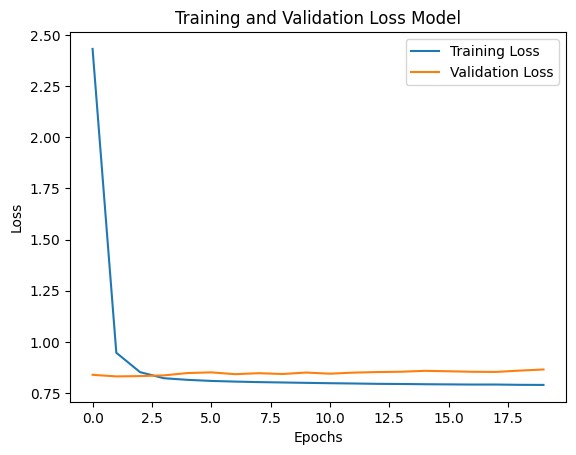

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss starting from epoch 3
plt.plot(history.epoch, history.history['loss'], label='Training Loss')

# Plot validation loss starting from epoch 3
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Model")

# Adding legend
plt.legend()

# Show the plot
plt.show()


## Save model untuk keperluan deploy

In [ ]:
model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import time

# Define the path to save the model
saved_model_path = "/tmp/saved_models/{}".format(int(time.time()))

# Save the model in the TensorFlow SavedModel format
model.save(saved_model_path, save_format='tf')

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
    

In [ ]:
!tensorflowjs_converter \
 --input_format=tf_saved_model \
 /tmp/saved_models/1718364969 \
 /tmp/model

2024-06-14 11:40:14.759392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-14 11:40:17.369047: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


# Contoh hasil prediksi model

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')


In [ ]:
num_items = 742
def recommend_items(model, user_id, num_recommendations=10):
    user_input = np.array([user_id] * num_items)

    place_id_input = np.array(place_data['place_id'])
    category_input = np.array(place_data['category'])
    city_input = np.array(place_data['city'])
    rating_input = np.array(place_data['rating'])
    verified_input = np.array(place_data['verified'])

    predictions = model.predict([user_input, place_id_input, category_input, city_input, rating_input, verified_input])
    predicted_ratings = pd.Series(predictions.flatten(), index=place_id_input)

    top_items = predicted_ratings.nlargest(num_recommendations).index
    index_place = place_data['place_id'].astype('category').cat.categories[top_items]
    filtered_data = tourist_resto_data.loc[tourist_resto_data['place_id'].isin(index_place), ['name', 'city']]
    return index_place, filtered_data

In [ ]:
index, recommendations = recommend_items(model, user_id=0)
print("Recommendations for User 1 : ", index, "\n", recommendations)

24/24 [==============================] - 0s 3ms/step
Recommendations for User 1 :  Index([584, 622, 241, 142, 370, 30, 612, 230, 77, 632], dtype='int64') 
                                      name               city
29              Top Selfie Kembang Lampir   Magelang Regency
76   VW Tour Borobudur (by SVARGA WISATA)   Magelang Regency
141    Dewi Kano Tourism Village Kaligono  Purworejo Regency
229                         Puncak Seroja   Wonosobo Regency
240                   Alun - Alun Sapuran   Wonosobo Regency
369                       Bakmi Jendralan      Magelang City
583                  Krishna Resto Garden   Wonosobo Regency
611                     ALURE Food Corner   Wonosobo Regency
621    DJAGONGAN DJADOEL Resto and Coffee   Wonosobo Regency
631                   Rumah Makan Harmoni   Wonosobo Regency


In [ ]:
index, recommendations = recommend_items(model, user_id=99)
print("Recommendations for User 100 :\n", recommendations)